<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/main/UFC_automated_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Automated Scoring

The goal of this notebook is to:
* Read in stored, scraped UFC data and convert it into a dataset ready for ML models
* Train, test, and analyze ML models

Functional as of April 2021

## Read in stored data

In [1]:
import numpy as np
import pandas as pd

In [2]:
STORED_FIGHT_TABLE = pd.read_csv('FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv')

In [3]:
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2,0,24,16,68.0,33.0,49,31,0,1,NaN,50.0,0,0,0,0,NaN,NaN,Pedro Rizzo,David Abbott,12,16,0,0,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,60.0,NaN,5,0,1,0,NaN,NaN,Tsuyoshi Kohsaka,Pete Williams,7,6,4,7,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,100.0,NaN,1,0,0,0,NaN,NaN,Ebenezer Fontes Braga,Jeremy Horn,6,0,1,3,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke


In [4]:
# Clean dataset: Only decisions with clear winners
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[STORED_FIGHT_TABLE["Method"].str.contains("DEC")]
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[(STORED_FIGHT_TABLE["Winner"] == 1) | (STORED_FIGHT_TABLE["Winner"] == 0)]
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,100.0,16.0,0,1,0,0,NaN,NaN,Pat Miletich,Jorge Patino,9,5,4,1,14,13,20,16,2,2,5,1,0,U-DEC
5881,0,0,16,25,55.0,47.0,29,58,0,2,NaN,33.0,0,0,0,0,NaN,NaN,Pedro Rizzo,Mark Coleman,9,23,0,0,7,2,15,7,1,0,0,18,0,S-DEC
5883,1,0,42,34,31.0,53.0,57,41,0,0,NaN,0.0,1,0,0,0,NaN,NaN,Mikey Burnett,Townsend Saunders,28,7,9,14,5,13,21,20,19,14,2,0,0,U-DEC
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC


In [5]:
X = STORED_FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = STORED_FIGHT_TABLE[['Winner']]

In [6]:
X

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,115,42,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,0.0,0.0,0,0,0,0,39.0,0.0,54,55,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,0.0,33.0,0,2,0,0,2.0,701.0,11,24,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,40,30,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,0.0,44.0,0,0,0,0,3.0,141.0,74,40,12,20,4,20,88,77,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,100.0,16.0,0,1,0,0,0.0,0.0,9,5,4,1,14,13,20,16,2,2,5,1
5881,0,0,16,25,55.0,47.0,29,58,0,2,0.0,33.0,0,0,0,0,0.0,0.0,9,23,0,0,7,2,15,7,1,0,0,18
5883,1,0,42,34,31.0,53.0,57,41,0,0,0.0,0.0,1,0,0,0,0.0,0.0,28,7,9,14,5,13,21,20,19,14,2,0
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,0.0,0.0,2,2,12,20,5,2,4,1,15,23,0,0


In [7]:
y

,Winner
0,0
1,0
2,1
3,0
4,0
...,...
5880,0
5881,0
5883,0
5889,0


## Setup train/validate/test split with data augmentation

TODO: Add in smarter data augmentation that create new datapoints nearby.

In [8]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table


def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [10]:
# Expect equal number of examples in Fighter 0 as Fighter 1 from data augmentation
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [11]:
X_train

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
1730,0,0,33,66,33.0,39.0,76,81,1,4,100.0,80.0,0,0,0,0,17.0,169.0,22,33,8,19,3,14,31,53,2,8,0,5
4671,0,0,28,14,31.0,25.0,83,27,1,3,100.0,60.0,1,1,0,1,27.0,404.0,17,2,8,6,3,6,9,9,15,3,4,2
2465,0,0,104,27,67.0,37.0,193,32,7,0,63.0,0.0,0,2,0,0,522.0,63.0,73,23,26,4,5,0,24,20,32,5,48,2
2417,0,0,39,94,34.0,54.0,67,140,4,0,40.0,0.0,0,0,0,0,329.0,37.0,20,82,7,9,12,3,38,94,0,0,1,0
5204,1,0,26,16,39.0,40.0,79,155,2,1,100.0,50.0,3,0,2,1,648.0,155.0,23,11,3,2,0,3,4,14,2,1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,0,0,87,87,34.0,41.0,87,98,0,0,0.0,0.0,0,0,0,0,24.0,102.0,60,58,16,14,11,15,80,84,7,3,0,0
2849,0,0,42,35,43.0,49.0,98,43,1,9,50.0,56.0,0,0,0,0,5.0,475.0,27,30,14,4,1,1,20,18,20,5,2,12
2057,0,0,50,18,54.0,50.0,96,52,1,6,100.0,85.0,2,0,0,0,1.0,600.0,27,10,16,1,7,7,31,9,1,1,18,8
26,0,0,71,27,47.0,39.0,131,32,3,2,75.0,50.0,0,1,1,1,280.0,209.0,54,16,14,10,3,1,48,26,4,1,19,0


In [12]:
y_train

,Winner
1730,1
4671,0
2465,0
2417,1
5204,0
...,...
2949,0
2849,1
2057,0
26,0


In [13]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (2408, 30)
X_valid.shape = (1188, 30)
X_test.shape = (1774, 30)
y_train.shape = (2408, 1)
y_valid.shape = (1188, 1)
y_test.shape = (1774, 1)


## Train and test ML models

TODO: Play around with PyTorch, add in data augmentation like SMOTE, see if normalizing, standardizing, extracting difference features helps.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_predIdxs_and_trueIdxs(classifier, X, y):
    predIdxs = np.where(classifier.predict(X) > 0.5, 1, 0)
    trueIdxs = y
    return predIdxs, trueIdxs

def plot_confusion_matrix(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    cm = confusion_matrix(trueIdxs, predIdxs)
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fighter 0 Win", "Fighter 1 Win"])
    cmDisplay.plot()
    
def print_classification_report(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    print(classification_report(trueIdxs, predIdxs, target_names=["Fighter 0 Win", "Fighter 1 Win"]))

### Random forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 0.8945182724252492
accuracy_valid = 0.8392255892255892


<BarContainer object of 30 artists>

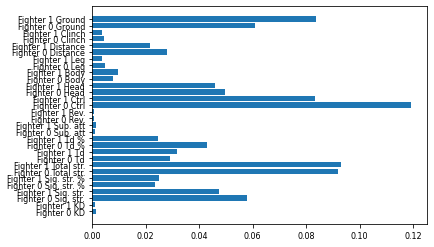

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_clf.fit(X_train, y_train)

# Validate
accuracy_train = random_forest_clf.score(X_train, y_train)
accuracy_valid = random_forest_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, random_forest_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.84      0.84       594
Fighter 1 Win       0.84      0.84      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



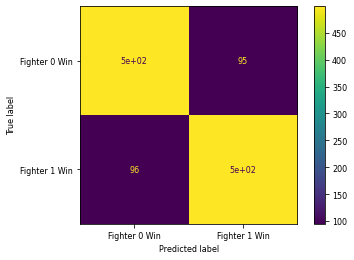

In [16]:
plot_confusion_matrix(random_forest_clf, X_valid, y_valid)
print_classification_report(random_forest_clf, X_valid, y_valid)

### Extra trees

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 1.0
accuracy_valid = 0.851010101010101


<BarContainer object of 30 artists>

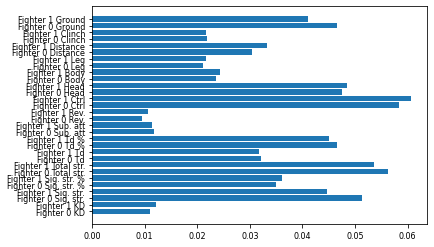

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

# Train
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees_clf.fit(X_train, y_train)

# Validate
accuracy_train = extra_trees_clf.score(X_train, y_train)
accuracy_valid = extra_trees_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, extra_trees_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.86      0.85       594
Fighter 1 Win       0.86      0.84      0.85       594

     accuracy                           0.85      1188
    macro avg       0.85      0.85      0.85      1188
 weighted avg       0.85      0.85      0.85      1188



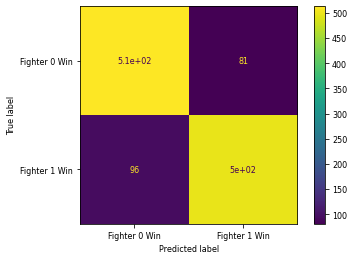

In [18]:
plot_confusion_matrix(extra_trees_clf, X_valid, y_valid)
print_classification_report(extra_trees_clf, X_valid, y_valid)

### MLP

In [19]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = mlp_clf.score(X_train, y_train)
accuracy_valid = mlp_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.7657807308970099
accuracy_valid = 0.7617845117845118


               precision    recall  f1-score   support

Fighter 0 Win       0.94      0.56      0.70       594
Fighter 1 Win       0.69      0.96      0.80       594

     accuracy                           0.76      1188
    macro avg       0.81      0.76      0.75      1188
 weighted avg       0.81      0.76      0.75      1188



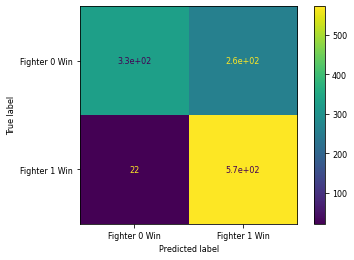

In [20]:
plot_confusion_matrix(mlp_clf, X_valid, y_valid)
print_classification_report(mlp_clf, X_valid, y_valid)

### SVM

In [21]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = svm_clf.score(X_train, y_train)
accuracy_valid = svm_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8567275747508306
accuracy_valid = 0.8333333333333334


               precision    recall  f1-score   support

Fighter 0 Win       0.83      0.83      0.83       594
Fighter 1 Win       0.83      0.83      0.83       594

     accuracy                           0.83      1188
    macro avg       0.83      0.83      0.83      1188
 weighted avg       0.83      0.83      0.83      1188



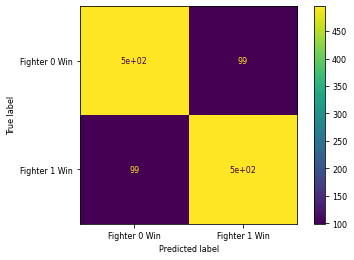

In [22]:
plot_confusion_matrix(svm_clf, X_valid, y_valid)
print_classification_report(svm_clf, X_valid, y_valid)

In [23]:
# SVM linear kernel
svm_linear_clf = SVC(kernel='linear', random_state=1).fit(X_train, y_train)
accuracy_train = svm_linear_clf.score(X_train, y_train)
accuracy_valid = svm_linear_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8621262458471761
accuracy_valid = 0.8585858585858586


<BarContainer object of 30 artists>

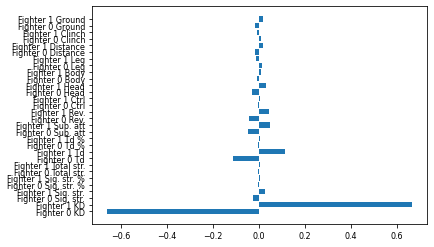

In [24]:
# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, svm_linear_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



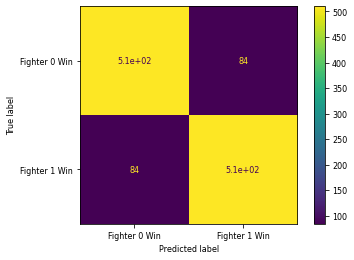

In [25]:
plot_confusion_matrix(svm_linear_clf, X_valid, y_valid)
print_classification_report(svm_linear_clf, X_valid, y_valid)

### XGBoost

In [26]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

accuracy_train = xgb_clf.score(X_train, y_train)
accuracy_valid = xgb_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.9090531561461794
accuracy_valid = 0.8417508417508418


               precision    recall  f1-score   support

Fighter 0 Win       0.84      0.84      0.84       594
Fighter 1 Win       0.84      0.84      0.84       594

     accuracy                           0.84      1188
    macro avg       0.84      0.84      0.84      1188
 weighted avg       0.84      0.84      0.84      1188



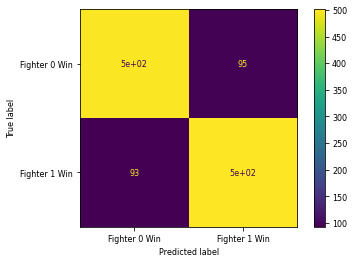

In [27]:
plot_confusion_matrix(xgb_clf, X_valid, y_valid)
print_classification_report(xgb_clf, X_valid, y_valid)

### Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression
logistic_regression_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 0.8608803986710963
accuracy_valid = 0.8594276094276094


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



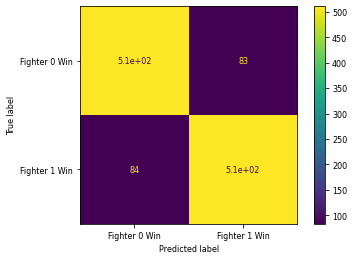

In [29]:
plot_confusion_matrix(logistic_regression_clf, X_valid, y_valid)
print_classification_report(logistic_regression_clf, X_valid, y_valid)

accuracy_train = 0.8658637873754153
accuracy_valid = 0.8577441077441077


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 30 artists>

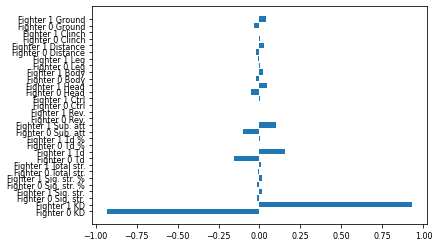

In [30]:
logistic_regression_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_l1_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_l1_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, logistic_regression_l1_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       0.86      0.86      0.86       594
Fighter 1 Win       0.86      0.86      0.86       594

     accuracy                           0.86      1188
    macro avg       0.86      0.86      0.86      1188
 weighted avg       0.86      0.86      0.86      1188



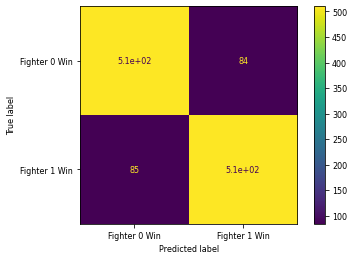

In [31]:
plot_confusion_matrix(logistic_regression_l1_clf, X_valid, y_valid)
print_classification_report(logistic_regression_l1_clf, X_valid, y_valid)

### KNN classifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

accuracy_train = knn_clf.score(X_train, y_train)
accuracy_valid = knn_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


accuracy_train = 0.8388704318936877
accuracy_valid = 0.8131313131313131


               precision    recall  f1-score   support

Fighter 0 Win       0.79      0.85      0.82       594
Fighter 1 Win       0.84      0.78      0.81       594

     accuracy                           0.81      1188
    macro avg       0.81      0.81      0.81      1188
 weighted avg       0.81      0.81      0.81      1188



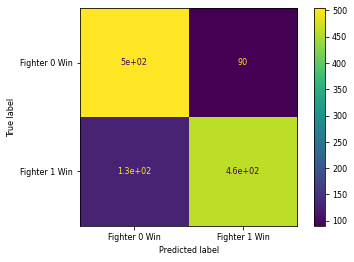

In [33]:
plot_confusion_matrix(knn_clf, X_valid, y_valid)
print_classification_report(knn_clf, X_valid, y_valid)

### Gradient boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

accuracy_train = gradient_boosting_clf.score(X_train, y_train)
accuracy_valid = gradient_boosting_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8799833887043189
accuracy_valid = 0.8232323232323232


               precision    recall  f1-score   support

Fighter 0 Win       0.82      0.82      0.82       594
Fighter 1 Win       0.82      0.82      0.82       594

     accuracy                           0.82      1188
    macro avg       0.82      0.82      0.82      1188
 weighted avg       0.82      0.82      0.82      1188



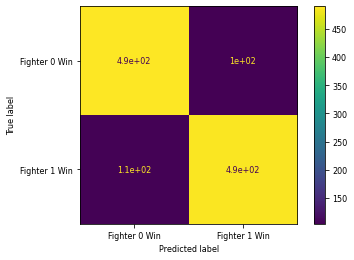

In [35]:
plot_confusion_matrix(gradient_boosting_clf, X_valid, y_valid)
print_classification_report(gradient_boosting_clf, X_valid, y_valid)

### Adaboost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

accuracy_train = adaboost_clf.score(X_train, y_train)
accuracy_valid = adaboost_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8700166112956811
accuracy_valid = 0.8181818181818182


               precision    recall  f1-score   support

Fighter 0 Win       0.82      0.82      0.82       594
Fighter 1 Win       0.82      0.82      0.82       594

     accuracy                           0.82      1188
    macro avg       0.82      0.82      0.82      1188
 weighted avg       0.82      0.82      0.82      1188



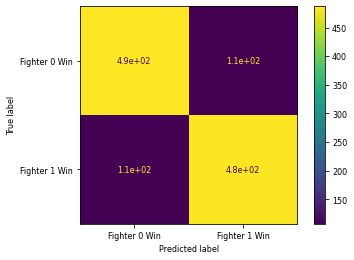

In [37]:
plot_confusion_matrix(adaboost_clf, X_valid, y_valid)
print_classification_report(adaboost_clf, X_valid, y_valid)

### Standardize features and break into fighter 0 and 1

In [38]:
fighter0_columns = [col for col in X_train.columns if "Fighter 0" in col]
fighter1_columns = [col for col in X_train.columns if "Fighter 1" in col]

X0_train = X_train[fighter0_columns]
X1_train = X_train[fighter1_columns]
X0_valid = X_valid[fighter0_columns]
X1_valid = X_valid[fighter1_columns]
X0_test = X_test[fighter0_columns]
X1_test = X_test[fighter1_columns]

X_train_new = pd.concat([X0_train, X1_train], axis=1)
X_valid_new = pd.concat([X0_valid, X1_valid], axis=1) 
X_test_new = pd.concat([X0_test, X1_test], axis=1)

means, stds = X_train_new.mean(), X_train_new.std()
X_train_new_normal = (X_train_new - means) / stds
X_valid_new_normal = (X_valid_new - means) / stds
X_test_new_normal = (X_test_new - means) / stds

In [39]:
X_train_new

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1730,0,33,33.0,76,1,100.0,0,0,17.0,22,8,3,31,2,0,0,66,39.0,81,4,80.0,0,0,169.0,33,19,14,53,8,5
4671,0,28,31.0,83,1,100.0,1,0,27.0,17,8,3,9,15,4,0,14,25.0,27,3,60.0,1,1,404.0,2,6,6,9,3,2
2465,0,104,67.0,193,7,63.0,0,0,522.0,73,26,5,24,32,48,0,27,37.0,32,0,0.0,2,0,63.0,23,4,0,20,5,2
2417,0,39,34.0,67,4,40.0,0,0,329.0,20,7,12,38,0,1,0,94,54.0,140,0,0.0,0,0,37.0,82,9,3,94,0,0
5204,1,26,39.0,79,2,100.0,3,2,648.0,23,3,0,4,2,20,0,16,40.0,155,1,50.0,0,1,155.0,11,2,3,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,0,87,34.0,87,0,0.0,0,0,24.0,60,16,11,80,7,0,0,87,41.0,98,0,0.0,0,0,102.0,58,14,15,84,3,0
2849,0,42,43.0,98,1,50.0,0,0,5.0,27,14,1,20,20,2,0,35,49.0,43,9,56.0,0,0,475.0,30,4,1,18,5,12
2057,0,50,54.0,96,1,100.0,2,0,1.0,27,16,7,31,1,18,0,18,50.0,52,6,85.0,0,0,600.0,10,1,7,9,1,8
26,0,71,47.0,131,3,75.0,0,1,280.0,54,14,3,48,4,19,0,27,39.0,32,2,50.0,1,1,209.0,16,10,1,26,1,0


In [40]:
X_train_new_normal

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1730,-0.305299,-0.534333,-0.750733,-0.016341,-0.278075,2.083169,-0.430413,-0.384637,-0.874148,-0.392728,-0.252079,-0.586382,-0.182997,-0.616028,-0.606073,-0.305299,0.549721,-0.272087,0.109057,1.192504,1.486555,-0.430413,-0.384637,-0.135387,0.108843,0.990861,0.603269,0.568862,0.079259,-0.064462
4671,-0.305299,-0.698583,-0.910282,0.159217,-0.278075,2.083169,0.646962,-0.384637,-0.825545,-0.620714,-0.252079,-0.586382,-0.934856,0.890427,-0.172784,-0.305299,-1.158485,-1.388928,-1.245250,0.702311,0.889941,0.646962,1.659969,1.006776,-1.304674,-0.478068,-0.261931,-0.934856,-0.500146,-0.389429
2465,-0.305299,1.798025,1.961593,2.917992,2.663083,0.979433,-0.430413,-0.384637,1.580288,1.932736,1.781823,-0.370081,-0.422225,2.860406,4.593386,-0.305299,-0.731433,-0.431636,-1.119851,-0.768267,-0.899901,1.724338,-0.384637,-0.650576,-0.347131,-0.704057,-0.910832,-0.558927,-0.268384,-0.389429
2417,-0.305299,-0.337232,-0.670959,-0.242059,1.192504,0.293327,-0.430413,-0.384637,0.642256,-0.483922,-0.365074,0.386969,0.056230,-0.847790,-0.497751,-0.305299,1.469524,0.924527,1.588764,-0.768267,-0.899901,-0.430413,-0.384637,-0.776943,2.343112,-0.139085,-0.586382,1.970053,-0.847790,-0.606073
5204,2.329682,-0.764283,-0.272087,0.058898,0.212118,2.083169,2.801714,3.704575,2.192682,-0.347131,-0.817052,-0.910832,-1.105733,-0.616028,1.560368,-0.305299,-1.092784,-0.192313,1.964960,-0.278075,0.591634,-0.430413,1.659969,-0.203431,-0.894298,-0.930046,-0.586382,-0.763979,-0.731909,-0.497751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,-0.305299,1.239573,-0.670959,0.259536,-0.768267,-0.899901,-0.430413,-0.384637,-0.840126,1.339971,0.651877,0.278819,1.491598,-0.036622,-0.606073,-0.305299,1.239573,-0.112539,0.535413,-0.768267,-0.899901,-0.430413,-0.384637,-0.461025,1.248776,0.425888,0.711419,1.628299,-0.500146,-0.606073
2849,-0.305299,-0.238682,0.047010,0.535413,-0.278075,0.591634,-0.430413,-0.384637,-0.932471,-0.164741,0.425888,-0.802682,-0.558927,1.469833,-0.389429,-0.305299,-0.468632,0.525656,-0.843974,3.643469,0.770618,-0.430413,-0.384637,1.351855,-0.027949,-0.704057,-0.802682,-0.627278,-0.268384,0.693792
2057,-0.305299,0.024119,0.924527,0.485254,-0.278075,2.083169,1.724338,-0.384637,-0.951912,-0.164741,0.651877,-0.153781,-0.182997,-0.731909,1.343724,-0.305299,-1.027084,0.605430,-0.618256,2.172890,1.635709,-0.430413,-0.384637,1.959389,-0.939896,-1.043041,-0.153781,-0.934856,-0.731909,0.260504
26,-0.305299,0.713971,0.366107,1.363046,0.702311,1.337402,-0.430413,1.659969,0.404103,1.066387,0.425888,-0.586382,0.397985,-0.384265,1.452046,-0.305299,-0.731433,-0.272087,-1.119851,0.212118,0.591634,0.646962,1.659969,0.059024,-0.666312,-0.026090,-0.802682,-0.353874,-0.731909,-0.606073


### Deep model

In [41]:
# FFN
import tensorflow as tf

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.Input(shape=X_train_new_normal.shape[1:]))
deep_model.add(tf.keras.layers.Dense(32, activation='relu'))
deep_model.add(tf.keras.layers.Dense(32, activation='relu'))
deep_model.add(tf.keras.layers.Dropout(0.5))
deep_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [42]:
H = deep_model.fit(X_train_new_normal, y_train, epochs=100, validation_data=(X_valid_new_normal, y_valid))
deep_model.evaluate(X_train_new_normal, y_train)
deep_model.evaluate(X_valid_new_normal, y_valid)

Epoch 1/100
76/76 [==============================] - 1s 9ms/step - loss: 0.6650 - accuracy: 0.6119 - val_loss: 0.4217 - val_accuracy: 0.8182
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.4246 - accuracy: 0.8101 - val_loss: 0.3521 - val_accuracy: 0.8300
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3687 - accuracy: 0.8391 - val_loss: 0.3400 - val_accuracy: 0.8476
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3536 - accuracy: 0.8474 - val_loss: 0.3357 - val_accuracy: 0.8476
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3444 - accuracy: 0.8589 - val_loss: 0.3336 - val_accuracy: 0.8502
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3320 - accuracy: 0.8579 - val_loss: 0.3338 - val_accuracy: 0.8519
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3511 - accuracy: 0.8479 - val_loss: 0.3343 - val_accuracy: 0.8569
Epoch 8/100
7

[0.5196441411972046, 0.8249158263206482]

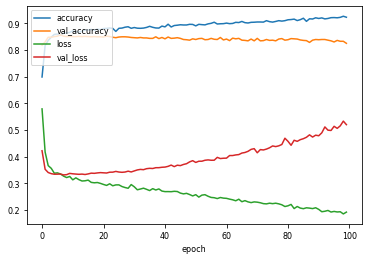

In [43]:
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

Fighter 0 Win       0.81      0.85      0.83       594
Fighter 1 Win       0.84      0.80      0.82       594

     accuracy                           0.82      1188
    macro avg       0.83      0.82      0.82      1188
 weighted avg       0.83      0.82      0.82      1188



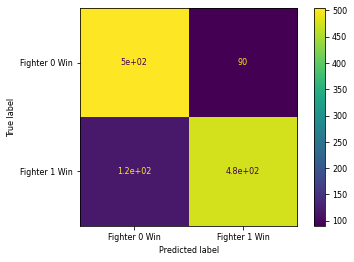

In [44]:
plot_confusion_matrix(deep_model, X_valid_new_normal, y_valid)
print_classification_report(deep_model, X_valid_new_normal, y_valid)

### Comparison Model

In [45]:
from tensorflow.keras.layers import Input, Lambda, Subtract, Activation
from tensorflow.keras.models import Model
def create_comparison_model(input_shape):
    num_features_per_fighter = input_shape[0] // 2

    model_ = tf.keras.models.Sequential()
    model_.add(tf.keras.Input(shape=num_features_per_fighter))
    model_.add(tf.keras.layers.Dense(32, activation='relu'))
    model_.add(tf.keras.layers.Dense(32, activation='relu'))
    model_.add(tf.keras.layers.Dropout(0.5))

    model_.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # Run cnn model on each frame
    input_tensor = Input(shape=input_shape)
    fighter0_state = Lambda(lambda x: x[:, :num_features_per_fighter], name='fighter0_state')(input_tensor)
    fighter1_state = Lambda(lambda x: x[:, num_features_per_fighter:], name='fighter1_state')(input_tensor)

    fighter0_score = model_(fighter0_state)
    fighter1_score = model_(fighter1_state)
    fighter0_score = Lambda(lambda x: x, name='fighter0_score')(fighter0_score)
    fighter1_score = Lambda(lambda x: x, name='fighter1_score')(fighter1_score)
    
    difference_score = Subtract(name='subtracter')([fighter1_score, fighter0_score])
    prediction = Activation('sigmoid')(difference_score)
    return Model(inputs=input_tensor, outputs=prediction)

In [46]:
comparison_model = create_comparison_model(X_train_new.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
comparison_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
comparison_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
fighter1_state (Lambda)         (None, 15)           0           input_3[0][0]                    
__________________________________________________________________________________________________
fighter0_state (Lambda)         (None, 15)           0           input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            1601        fighter0_state[0][0]             
                                                                 fighter1_state[0][0]         

In [47]:
H = comparison_model.fit(X_train_new_normal, y_train, epochs=100, validation_data=(X_valid_new_normal, y_valid))

Epoch 1/100
76/76 [==============================] - 1s 6ms/step - loss: 0.6429 - accuracy: 0.6028 - val_loss: 0.4123 - val_accuracy: 0.8224
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.4250 - accuracy: 0.8093 - val_loss: 0.3729 - val_accuracy: 0.8325
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8233 - val_loss: 0.3648 - val_accuracy: 0.8375
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3843 - accuracy: 0.8372 - val_loss: 0.3612 - val_accuracy: 0.8409
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8438 - val_loss: 0.3625 - val_accuracy: 0.8392
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3926 - accuracy: 0.8469 - val_loss: 0.3586 - val_accuracy: 0.8476
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8564 - val_loss: 0.3561 - val_accuracy: 0.8502
Epoch 8/100
7

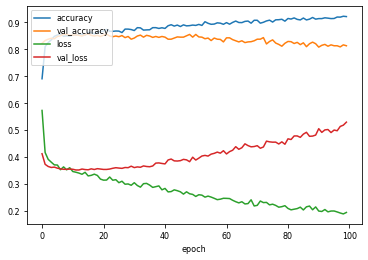

In [48]:
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

Fighter 0 Win       0.80      0.83      0.82       594
Fighter 1 Win       0.82      0.80      0.81       594

     accuracy                           0.81      1188
    macro avg       0.81      0.81      0.81      1188
 weighted avg       0.81      0.81      0.81      1188



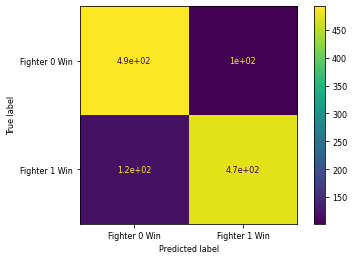

In [49]:
plot_confusion_matrix(comparison_model, X_valid_new_normal, y_valid)
print_classification_report(comparison_model, X_valid_new_normal, y_valid)

In [50]:
lo, hi = 11, 20

In [51]:
X_test_new[lo:hi]

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1705,0,63,45.0,84,1,100.0,0,0,280.0,40,18,5,41,9,13,0,34,42.0,61,1,20.0,0,0,146.0,18,8,8,26,3,5
1058,0,77,44.0,125,0,0.0,0,0,0.0,29,28,20,65,8,4,1,67,43.0,91,0,0.0,0,0,278.0,21,31,15,54,8,5
619,0,134,44.0,135,0,0.0,0,0,2.0,85,32,17,132,2,0,0,157,51.0,157,0,0.0,0,0,45.0,67,15,75,156,1,0
3465,0,16,34.0,51,2,50.0,3,0,521.0,10,4,2,7,3,6,0,19,26.0,44,0,0.0,0,1,14.0,14,2,3,19,0,0
5609,0,88,47.0,96,2,22.0,1,0,154.0,62,16,10,51,33,4,0,57,38.0,64,0,0.0,0,0,19.0,55,1,1,43,14,0
2047,0,20,50.0,83,2,33.0,0,0,744.0,12,7,1,4,6,10,0,11,36.0,28,0,0.0,0,1,40.0,5,4,2,6,5,0
2097,0,61,36.0,68,2,40.0,0,0,52.0,39,6,16,57,3,1,0,82,38.0,99,0,0.0,0,1,178.0,55,15,12,75,5,2
251,0,20,27.0,29,5,45.0,0,0,416.0,7,2,11,18,2,0,0,47,52.0,54,1,20.0,0,2,72.0,34,4,9,35,6,6
965,0,53,62.0,95,2,50.0,0,0,551.0,41,7,5,31,3,19,0,30,42.0,86,1,100.0,0,0,101.0,16,5,9,24,4,2


In [52]:
X_test_new_normal[lo:hi]

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
1705,-0.305299,0.451171,0.206558,0.184297,-0.278075,2.083169,-0.430413,-0.384637,0.404103,0.428024,0.877866,-0.370081,0.158757,0.195140,0.802114,-0.305299,-0.501482,-0.032764,-0.392538,-0.278075,-0.303287,-0.430413,-0.384637,-0.247173,-0.575117,-0.252079,-0.045631,-0.353874,-0.500146,-0.064462
1058,-0.305299,0.911072,0.126784,1.212567,-0.768267,-0.899901,-0.430413,-0.384637,-0.956773,-0.073547,2.007812,1.252169,0.978966,0.079259,-0.172784,2.329682,0.582571,0.047010,0.359855,-0.768267,-0.899901,-0.430413,-0.384637,0.394382,-0.438325,2.346795,0.711419,0.603037,0.079259,-0.064462
619,-0.305299,2.783528,0.126784,1.463365,-0.768267,-0.899901,-0.430413,-0.384637,-0.947052,2.479904,2.459790,0.927719,3.268719,-0.616028,-0.606073,-0.305299,3.539080,0.685204,2.015120,-0.768267,-0.899901,-0.430413,-0.384637,-0.738060,1.659152,0.538883,7.200420,4.088928,-0.731909,-0.606073
3465,-0.305299,-1.092784,-0.670959,-0.643336,0.212118,0.591634,2.801714,-0.384637,1.575427,-0.939896,-0.704057,-0.694532,-1.003207,-0.500146,0.043860,-0.305299,-0.994234,-1.309153,-0.818894,-0.768267,-0.899901,-0.430413,1.659969,-0.888729,-0.757506,-0.930046,-0.586382,-0.593102,-0.847790,-0.606073
5609,-0.305299,1.272423,0.366107,0.485254,0.212118,-0.243626,0.646962,-0.384637,-0.208291,1.431165,0.651877,0.170669,0.500511,2.976287,-0.172784,-0.305299,0.254070,-0.351862,-0.317299,-0.768267,-0.899901,-0.430413,-0.384637,-0.864427,1.111984,-1.043041,-0.802682,0.227107,0.774546,-0.606073
2047,-0.305299,-0.961384,0.605430,0.159217,0.212118,0.084512,-0.430413,-0.384637,2.659267,-0.848701,-0.365074,-0.802682,-1.105733,-0.152503,0.477148,-0.305299,-1.257035,-0.511410,-1.220170,-0.768267,-0.899901,-0.430413,1.659969,-0.762362,-1.167882,-0.704057,-0.694532,-1.037383,-0.268384,-0.606073
2097,-0.305299,0.385470,-0.511410,-0.216980,0.212118,0.293327,-0.430413,-0.384637,-0.704039,0.382427,-0.478068,0.819569,0.705563,-0.500146,-0.497751,-0.305299,1.075323,-0.351862,0.560493,-0.768267,-0.899901,-0.430413,1.659969,-0.091645,1.111984,0.538883,0.386969,1.320720,-0.268384,-0.389429
251,-0.305299,-0.961384,-1.229379,-1.195091,1.682697,0.442481,-0.430413,-0.384637,1.065099,-1.076688,-0.930046,0.278819,-0.627278,-0.616028,-0.606073,-0.305299,-0.074431,0.764979,-0.568096,-0.278075,-0.303287,-0.430413,3.704575,-0.606833,0.154440,-0.704057,0.062519,-0.046296,-0.152503,0.043860
965,-0.305299,0.122669,1.562722,0.460174,0.212118,0.591634,-0.430413,-0.384637,1.721235,0.473621,-0.365074,-0.370081,-0.182997,-0.500146,1.452046,-0.305299,-0.632883,-0.032764,0.234456,-0.278075,2.083169,-0.430413,-0.384637,-0.465885,-0.666312,-0.591063,0.062519,-0.422225,-0.384265,-0.389429


In [53]:
comparison_model.predict(X_test_new_normal[lo:hi])

array([[1.6789138e-03],
       [9.8863983e-01],
       [9.5752114e-01],
       [6.5197438e-02],
       [2.5165081e-03],
       [1.8355846e-03],
       [9.5972747e-01],
       [9.2083681e-01],
       [1.0770145e-04]], dtype=float32)

In [54]:
y_test[lo:hi]

,Winner
1705,0
1058,1
619,1
3465,0
5609,0
2047,0
2097,1
251,1
965,0


In [55]:
subtracter = comparison_model.get_layer('subtracter').output
subtracter = Model(comparison_model.input, subtracter)
subtracter.predict(X_test_new_normal[lo:hi])

array([[-6.3879266],
       [ 4.4662194],
       [ 3.1153412],
       [-2.662915 ],
       [-5.9823666],
       [-6.298544 ],
       [ 3.1709793],
       [ 2.4537714],
       [-9.1361475]], dtype=float32)

In [56]:
fighter0_score = comparison_model.get_layer('fighter0_score').output
fighter0_score = Model(comparison_model.input, fighter0_score)
fighter0_score.predict(X_test_new_normal[lo:hi])

array([[ 7.496221  ],
       [ 3.3026195 ],
       [ 8.64645   ],
       [ 2.662915  ],
       [ 8.077615  ],
       [ 6.298544  ],
       [ 2.829841  ],
       [ 0.82426286],
       [11.2429085 ]], dtype=float32)

In [57]:
fighter1_score = comparison_model.get_layer('fighter1_score').output
fighter1_score = Model(comparison_model.input, fighter1_score)
fighter1_score.predict(X_test_new_normal[lo:hi])

array([[ 1.1082946],
       [ 7.768839 ],
       [11.761791 ],
       [ 0.       ],
       [ 2.0952482],
       [ 0.       ],
       [ 6.00082  ],
       [ 3.2780342],
       [ 2.1067607]], dtype=float32)

In [58]:
columns = list(X_test_new_normal.columns)
new_columns = columns[len(columns)//2:] + columns[:len(columns)//2]
switcheroo = X_test_new_normal[new_columns]
fighter1_score.predict(switcheroo[lo:hi])

array([[ 7.496221  ],
       [ 3.3026195 ],
       [ 8.64645   ],
       [ 2.662915  ],
       [ 8.077615  ],
       [ 6.298544  ],
       [ 2.829841  ],
       [ 0.82426286],
       [11.2429085 ]], dtype=float32)

In [59]:
fighter0_score.predict(switcheroo[lo:hi])

array([[ 1.1082946],
       [ 7.768839 ],
       [11.761791 ],
       [ 0.       ],
       [ 2.0952482],
       [ 0.       ],
       [ 6.00082  ],
       [ 3.2780342],
       [ 2.1067607]], dtype=float32)

In [60]:
subtracter.predict(switcheroo[lo:hi])

array([[ 6.3879266],
       [-4.4662194],
       [-3.1153412],
       [ 2.662915 ],
       [ 5.9823666],
       [ 6.298544 ],
       [-3.1709793],
       [-2.4537714],
       [ 9.1361475]], dtype=float32)

In [61]:
comparison_model.predict(switcheroo[lo:hi])

array([[0.99832106],
       [0.01136014],
       [0.04247886],
       [0.93480253],
       [0.9974835 ],
       [0.9981644 ],
       [0.04027253],
       [0.07916322],
       [0.99989235]], dtype=float32)

In [62]:
deep_model.predict(X_test_new_normal[1:10])

array([[2.7348340e-01],
       [5.6614935e-02],
       [4.3564734e-05],
       [9.9049121e-01],
       [9.9227023e-01],
       [2.2236407e-03],
       [8.7417048e-01],
       [1.6659552e-08],
       [2.0882225e-01]], dtype=float32)

In [63]:
deep_model.predict(switcheroo[1:10])

array([[0.23818928],
       [0.8915566 ],
       [0.99470603],
       [0.11142445],
       [0.09841967],
       [0.9190571 ],
       [0.3515808 ],
       [1.        ],
       [0.6475867 ]], dtype=float32)